In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import shap
from wordcloud import WordCloud
from scipy.sparse import hstack
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')

### **1.0 Data Understanding**

In [3]:
# Data Overview
print("Initial Data Overview:")
df

Initial Data Overview:


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
# Basic information about the dataset
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# Check for unique values in each column
print("\nUnique values in each column:")
print(df.nunique())


Unique values in each column:
tweet_text                                            9065
emotion_in_tweet_is_directed_at                          9
is_there_an_emotion_directed_at_a_brand_or_product       4
dtype: int64


In [6]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [7]:
# Checking for duplicates
duplicates = df.duplicated(subset=['tweet_text'], keep=False)
print(f"\nNumber of duplicate tweets: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("Sample Duplicate Tweets:")
    print(df[duplicates][['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']].head())


Number of duplicate tweets: 46
Sample Duplicate Tweets:
                                           tweet_text  \
7   #SXSW is just starting, #CTIA is around the co...   
9   Counting down the days to #sxsw plus strong Ca...   
17  I just noticed DST is coming this weekend. How...   
20  Need to buy an iPad2 while I'm in Austin at #s...   
21  Oh. My. God. The #SXSW app for iPad is pure, u...   

   emotion_in_tweet_is_directed_at  \
7                          Android   
9                            Apple   
17                          iPhone   
20                            iPad   
21              iPad or iPhone App   

   is_there_an_emotion_directed_at_a_brand_or_product  
7                                    Positive emotion  
9                                    Positive emotion  
17                                   Negative emotion  
20                                   Positive emotion  
21                                   Positive emotion  



Target Variable Distribution:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


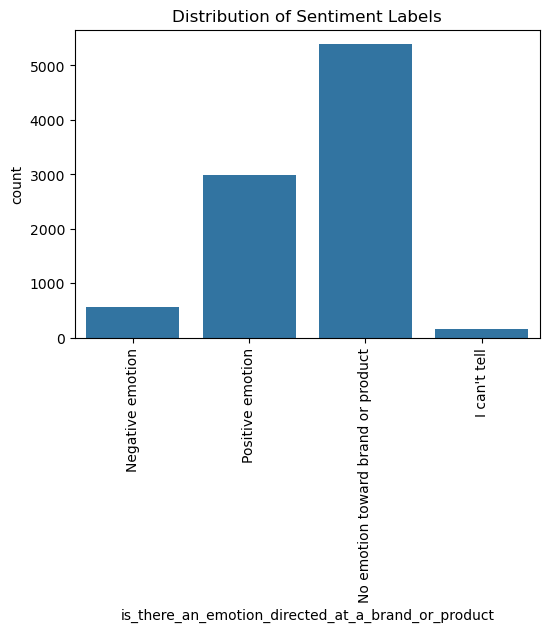

In [8]:
# Checking the distribution of the target variable
print("\nTarget Variable Distribution:")
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

# Visualizing the target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df)
plt.title('Distribution of Sentiment Labels')
plt.xticks(rotation=90)
plt.show()



Distribution of Products/Brands:
emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64


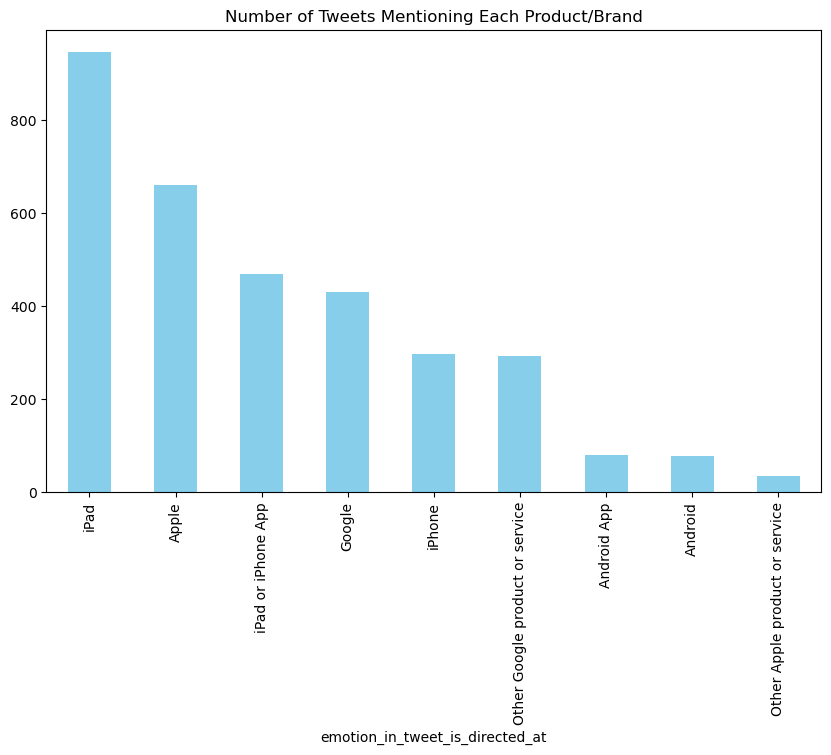

In [9]:
# Distribution of products/brands mentioned in the tweets
print("\nDistribution of Products/Brands:")
print(df['emotion_in_tweet_is_directed_at'].value_counts())

# Visualizing product mentions
plt.figure(figsize=(10,6))
df['emotion_in_tweet_is_directed_at'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Tweets Mentioning Each Product/Brand')
plt.xticks(rotation=90)
plt.show()

### **2.0 Data Cleaning**

#### **2.1 Changing Column Names**

In [10]:
# Rename the columns
df.rename(columns={
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'target'
}, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9092 non-null   object
 1   product  3291 non-null   object
 2   target   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None


#### **2.1 Handling Missing Values**

In [11]:
# Checking the number of missing values before cleaning
print("\nMissing Values before cleaning:")
print(df.isnull().sum())


Missing Values before cleaning:
tweet         1
product    5802
target        0
dtype: int64


In [12]:
df['product'].value_counts()

product
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [13]:
# Impute missing values in the 'product' column with "Unknown"
df['product'] = df['product'].fillna("Unknown")

In [14]:
# Drop rows where the tweet_text is missing (since no text is unusable)
df_cleaned = df.dropna(subset=['tweet'])

In [15]:
# Checking if there are any remaining missing values
print("\nMissing Values after cleaning:")
print(df_cleaned.isnull().sum())

# Shape of the cleaned dataset
print(f"\nDataset shape after removing missing values: {df_cleaned.shape}")


Missing Values after cleaning:
tweet      0
product    0
target     0
dtype: int64

Dataset shape after removing missing values: (9092, 3)


#### **2.3 Handling Duplicates**

In [16]:
# Checking for duplicates again after dropping nulls
duplicates_cleaned = df_cleaned.duplicated(subset=['tweet'], keep=False)
print(f"\nNumber of duplicate tweets before cleaning: {duplicates_cleaned.sum()}")
if duplicates_cleaned.sum() > 0:
    df_cleaned = df_cleaned.drop_duplicates(subset=['tweet'])
    print(f"Duplicates dropped. Remaining shape: {df_cleaned.shape}")


Number of duplicate tweets before cleaning: 46
Duplicates dropped. Remaining shape: (9065, 3)


#### **2.4 Handling Corrupted Data**

In [17]:
# Identifying tweets with unusual characters or non-English text
unusual_tweets = df_cleaned[df_cleaned['tweet'].apply(lambda x: any(ord(char) > 128 for char in x))]
print("\nSample tweets containing unusual characters or non-English text:")
print(unusual_tweets[['tweet', 'target']].head())


Sample tweets containing unusual characters or non-English text:
                                                tweet  \
38  @mention  - False Alarm: Google Circles Not Co...   
41  HootSuite - HootSuite Mobile for #SXSW ~ Updat...   
42  Hey #SXSW - How long do you think it takes us ...   
45  #IPad2 's Û÷#SmartCoverÛª Opens to Instant A...   
46  Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...   

                                target  
38                    Negative emotion  
41  No emotion toward brand or product  
42  No emotion toward brand or product  
45                    Positive emotion  
46                    Positive emotion  


In [18]:
# Removing rows with non-English or malformed tweets
df_cleaned = df_cleaned[~df_cleaned['tweet'].apply(lambda x: any(ord(char) > 128 for char in x))]

# Shape of the dataset after removing unusual characters
print(f"\nDataset shape after removing unusual characters: {df_cleaned.shape}")


Dataset shape after removing unusual characters: (8582, 3)


#### **2.5 Checking for Emojis**

In [19]:
# Function to check for emojis
def contains_emoji(text):
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"  # emoticons
                                 "\U0001F300-\U0001F5FF"  # symbols & pictographs
                                 "\U0001F680-\U0001F6FF"  # transport & map symbols
                                 "\U0001F700-\U0001F77F"  # alchemical symbols
                                 "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                 "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                 "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                 "\U0001FA00-\U0001FA6F"  # Chess Symbols
                                 "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                 "\u2600-\u26FF"          # Miscellaneous Symbols
                                 "\u2700-\u27BF"          # Dingbats
                                 "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Filter rows containing emojis
emoji_rows = df_cleaned[df_cleaned['tweet'].apply(lambda x: contains_emoji(x) if pd.notnull(x) else False)]

print(emoji_rows)

Empty DataFrame
Columns: [tweet, product, target]
Index: []


#### **2.6 Dropping Unecessary Rows**

In [20]:
df_cleaned['target'].value_counts()

target
No emotion toward brand or product    5068
Positive emotion                      2823
Negative emotion                       543
I can't tell                           148
Name: count, dtype: int64

In [21]:
# Drop rows where the target is "I can't tell"
df_cleaned = df_cleaned[df_cleaned['target'] != "I can't tell"]

In [22]:
# Define a mapping for the target values
mapping = {
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative'
}

# Replace the values in the target column
df_cleaned['target'] = df_cleaned['target'].map(mapping)

In [23]:
df_cleaned['target'].value_counts()

target
Neutral     5068
Positive    2823
Negative     543
Name: count, dtype: int64

In [24]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8434 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8434 non-null   object
 1   product  8434 non-null   object
 2   target   8434 non-null   object
dtypes: object(3)
memory usage: 263.6+ KB


#### **2.7 Cleaning the Tweet Column**

In [25]:
# Removing URLs, punctuation, special characters, and converting text to lowercase
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet text
    text = re.sub(r'@\w+|#\w+|\{link\}|\{mention\}', " ", text)
    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

df_cleaned['cleaned_text'] = df_cleaned['tweet'].apply(clean_text)

# Displaying some cleaned tweets
print("\nSample Cleaned Tweets:")
print(df_cleaned[['tweet', 'cleaned_text']].head())


Sample Cleaned Tweets:
                                               tweet  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

                                        cleaned_text  
0    i have a g iphone after  hrs tweeting at   i...  
1    know about    awesome ipadiphone app that yo...  
2    can not wait for    also they should sale th...  
3    i hope this years festival isnt as crashy as...  
4    great stuff on fri   marissa mayer google ti...  


In [26]:
# Removing stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_cleaned['cleaned_text'] = df_cleaned['cleaned_text'].apply(remove_stopwords)

# Displaying cleaned tweets without stopwords
print("\nSample Cleaned Tweets without stopwords:")
print(df_cleaned[['tweet', 'cleaned_text']].head())


Sample Cleaned Tweets without stopwords:
                                               tweet  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

                                        cleaned_text  
0  g iphone hrs tweeting dead need upgrade plugin...  
1  know awesome ipadiphone app youll likely appre...  
2                                     wait also sale  
3   hope years festival isnt crashy years iphone app  
4  great stuff fri marissa mayer google tim oreil...  


In [27]:
# Tokenization
df_cleaned['tokens'] = df_cleaned['cleaned_text'].apply(word_tokenize)

# Displaying some tokenized tweets
print("\nSample Tokenized Tweets:")
print(df_cleaned[['cleaned_text', 'tokens']].head())


Sample Tokenized Tweets:
                                        cleaned_text  \
0  g iphone hrs tweeting dead need upgrade plugin...   
1  know awesome ipadiphone app youll likely appre...   
2                                     wait also sale   
3   hope years festival isnt crashy years iphone app   
4  great stuff fri marissa mayer google tim oreil...   

                                              tokens  
0  [g, iphone, hrs, tweeting, dead, need, upgrade...  
1  [know, awesome, ipadiphone, app, youll, likely...  
2                                 [wait, also, sale]  
3  [hope, years, festival, isnt, crashy, years, i...  
4  [great, stuff, fri, marissa, mayer, google, ti...  


In [28]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df_cleaned['lemmatized_tokens'] = df_cleaned['tokens'].apply(lemmatize_words)

# Displaying some lemmatized tweets
print("\nSample Lemmatized Tokens:")
print(df_cleaned[['tokens', 'lemmatized_tokens']].head())


Sample Lemmatized Tokens:
                                              tokens  \
0  [g, iphone, hrs, tweeting, dead, need, upgrade...   
1  [know, awesome, ipadiphone, app, youll, likely...   
2                                 [wait, also, sale]   
3  [hope, years, festival, isnt, crashy, years, i...   
4  [great, stuff, fri, marissa, mayer, google, ti...   

                                   lemmatized_tokens  
0  [g, iphone, hr, tweeting, dead, need, upgrade,...  
1  [know, awesome, ipadiphone, app, youll, likely...  
2                                 [wait, also, sale]  
3  [hope, year, festival, isnt, crashy, year, iph...  
4  [great, stuff, fri, marissa, mayer, google, ti...  


In [29]:
# Preparing the final cleaned text for EDA and modeling by joining the lemmatized tokens
df_cleaned['final_cleaned_text'] = df_cleaned['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Displaying the final cleaned text
print("\nSample Final Cleaned Text:")
print(df_cleaned[['tweet', 'final_cleaned_text']].head())

# Final Dataset Overview
print(f"\nFinal cleaned dataset shape: {df_cleaned.shape}")
print("\nCleaned Data Overview:")
print(df_cleaned[['final_cleaned_text', 'target']].head())


Sample Final Cleaned Text:
                                               tweet  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

                                  final_cleaned_text  
0  g iphone hr tweeting dead need upgrade plugin ...  
1  know awesome ipadiphone app youll likely appre...  
2                                     wait also sale  
3     hope year festival isnt crashy year iphone app  
4  great stuff fri marissa mayer google tim oreil...  

Final cleaned dataset shape: (8434, 7)

Cleaned Data Overview:
                                  final_cleaned_text    target
0  g iphone hr tweeting dead need upgrade plugin ...  Negative
1  know awesome ipadiphone app youll likely appre...  Positive
2                                     wait also sale

In [30]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8434 entries, 0 to 9091
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               8434 non-null   object
 1   product             8434 non-null   object
 2   target              8434 non-null   object
 3   cleaned_text        8434 non-null   object
 4   tokens              8434 non-null   object
 5   lemmatized_tokens   8434 non-null   object
 6   final_cleaned_text  8434 non-null   object
dtypes: object(7)
memory usage: 527.1+ KB


In [31]:
df_cleaned = df_cleaned.reset_index(drop=True)

### **3.0 EDA**

#### **3.1 Univariate Analysis**

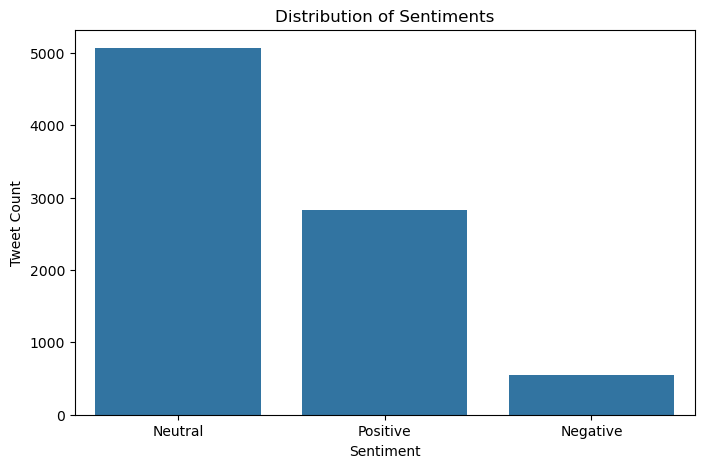

In [32]:
# Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df_cleaned, x='target', order=df_cleaned['target'].value_counts().index)
plt.title('Distribution of Sentiments')
plt.ylabel('Tweet Count')
plt.xlabel('Sentiment')
plt.show()


Tweet Length Statistics:
count    8434.000000
mean      104.401707
std        27.349292
min        11.000000
25%        85.000000
50%       108.000000
75%       126.000000
max       171.000000
Name: tweet_length, dtype: float64


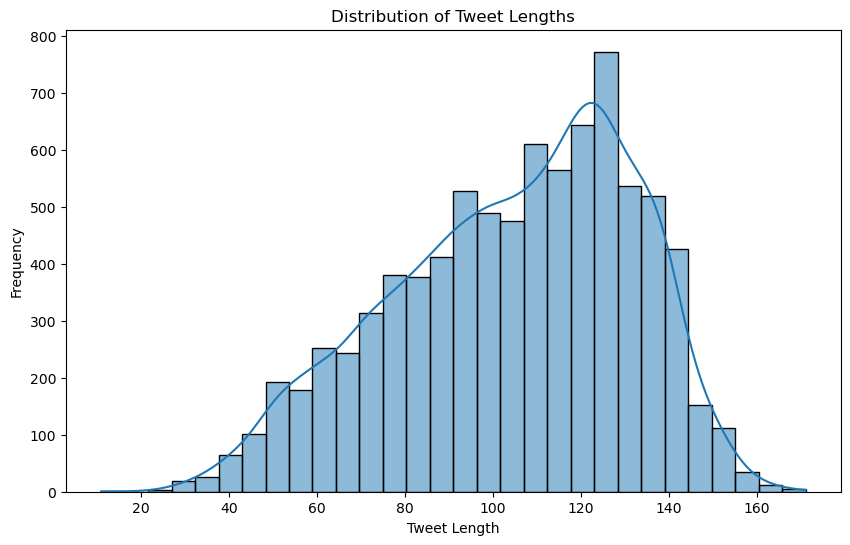

In [33]:
# Distribution of Tweet Lengths
df_cleaned['tweet_length'] = df_cleaned['tweet'].apply(len)

# Descriptive statistics of tweet lengths
print("\nTweet Length Statistics:")
print(df_cleaned['tweet_length'].describe())

# Visualizing tweet length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


#### **3.2 Bivariate Analysis**

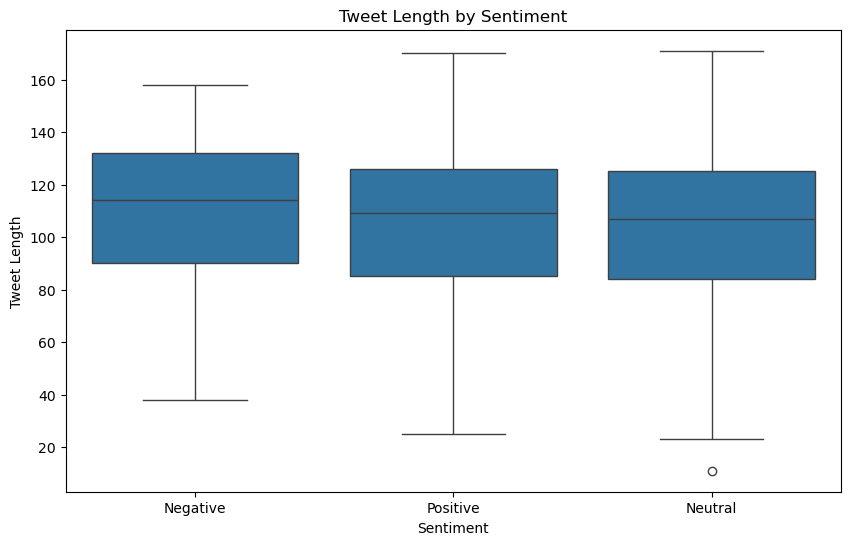

In [34]:
# Sentiment vs. Tweet Length
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='target', y='tweet_length')
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()

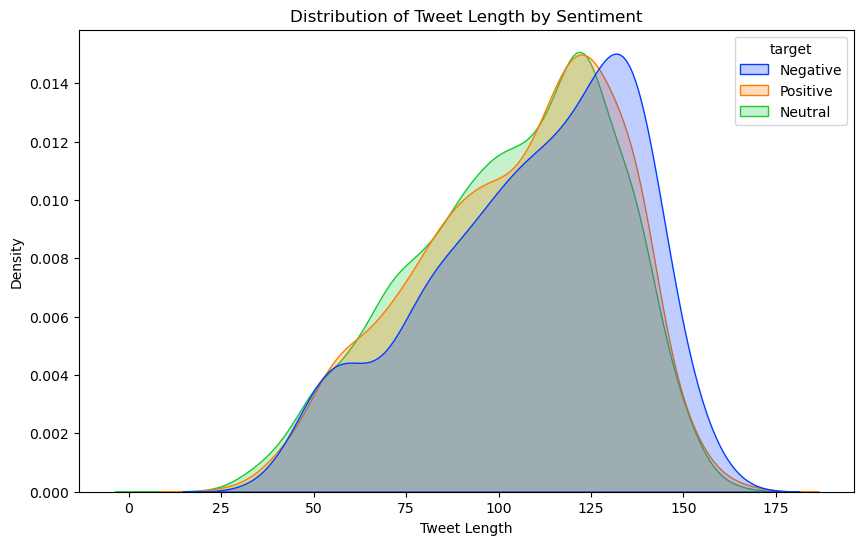

In [35]:
# KDE Plot (Kernel Density Estimation) for Sentiment vs Tweet Length
# This helps to see the distribution of tweet lengths across the different sentiments.
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cleaned, x='tweet_length', hue='target', fill=True, common_norm=False, palette='bright')
plt.title('Distribution of Tweet Length by Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Density')
plt.show()

In [36]:
# Most Common Words for Each Sentiment
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [37]:
# Getting the top 10 words for each sentiment
for sentiment in df_cleaned['target'].unique():
    print(f"\nMost Common Words in {sentiment} Sentiment Tweets:")
    top_words = get_top_n_words(df_cleaned[df_cleaned['target'] == sentiment]['final_cleaned_text'], 10)
    print(top_words)


Most Common Words in Negative Sentiment Tweets:
[('ipad', 160), ('iphone', 140), ('rt', 130), ('google', 120), ('apple', 88), ('app', 57), ('like', 41), ('store', 40), ('new', 39), ('need', 34)]

Most Common Words in Positive Sentiment Tweets:
[('ipad', 929), ('rt', 881), ('apple', 658), ('google', 604), ('store', 515), ('iphone', 414), ('app', 365), ('new', 332), ('austin', 225), ('popup', 213)]

Most Common Words in Neutral Sentiment Tweets:
[('rt', 1727), ('google', 1308), ('ipad', 1083), ('apple', 961), ('store', 834), ('new', 610), ('iphone', 602), ('austin', 529), ('amp', 505), ('launch', 424)]


In [38]:
# Word Clouds for Each Sentiment
def plot_wordcloud(text, title):
    wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

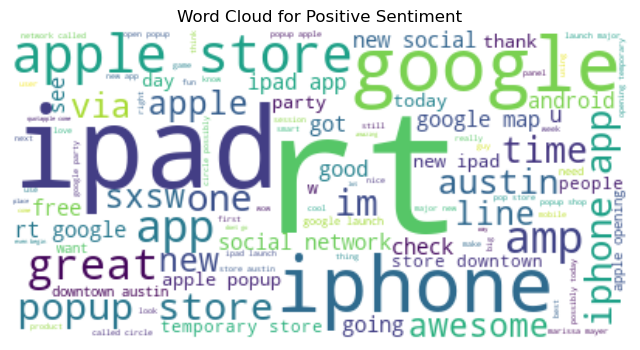

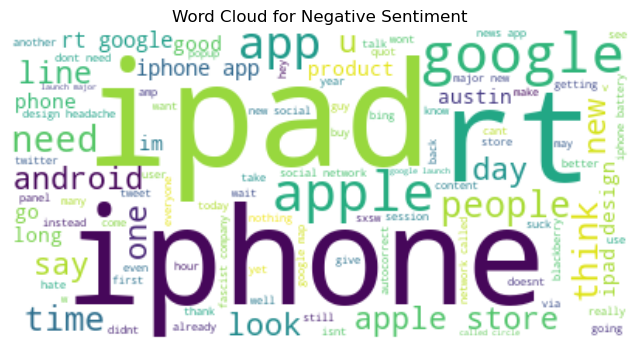

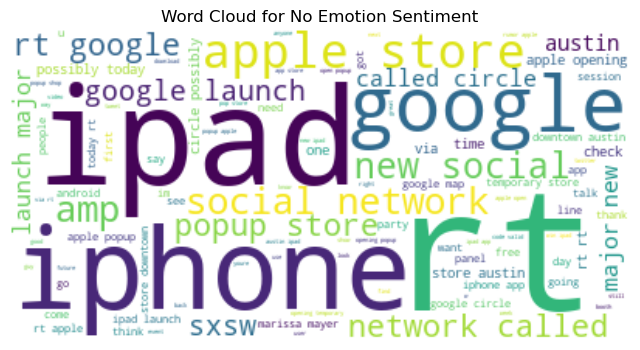

In [39]:
# WordCloud for Positive Sentiment
positive_tweets = ' '.join(df_cleaned[df_cleaned['target'] == 'Positive']['final_cleaned_text'])
plot_wordcloud(positive_tweets, 'Word Cloud for Positive Sentiment')

# WordCloud for Negative Sentiment
negative_tweets = ' '.join(df_cleaned[df_cleaned['target'] == 'Negative']['final_cleaned_text'])
plot_wordcloud(negative_tweets, 'Word Cloud for Negative Sentiment')

# WordCloud for Neutral/No Emotion
neutral_tweets = ' '.join(df_cleaned[df_cleaned['target'] == 'Neutral']['final_cleaned_text'])
plot_wordcloud(neutral_tweets, 'Word Cloud for No Emotion Sentiment')

In [40]:
# N-grams Analysis (Bigrams and Trigrams)
def get_top_n_ngrams(corpus, n=None, ngram_range=(2, 2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
# Top 10 Bigrams for Positive Sentiment
print("\nTop 10 Bigrams in Positive Sentiment Tweets:")
positive_bigrams = get_top_n_ngrams(df_cleaned[df_cleaned['target'] == 'Positive']['final_cleaned_text'], 10, (2, 2))
print(positive_bigrams)

# Top 10 Trigrams for Negative Sentiment
print("\nTop 10 Trigrams in Negative Sentiment Tweets:")
negative_trigrams = get_top_n_ngrams(df_cleaned[df_cleaned['target'] == 'Negative']['final_cleaned_text'], 10, (3, 3))
print(negative_trigrams)

# Top 10 Trigrams for Neutral Sentiment
print("\nTop 10 Trigrams in Neutral Sentiment Tweets:")
neutral_trigrams = get_top_n_ngrams(df_cleaned[df_cleaned['target'] == 'Neutral']['final_cleaned_text'], 10, (3, 3))
print(neutral_trigrams)


Top 10 Bigrams in Positive Sentiment Tweets:
[('apple store', 187), ('popup store', 121), ('iphone app', 96), ('google map', 78), ('social network', 77), ('rt google', 69), ('new social', 68), ('apple popup', 67), ('ipad app', 64), ('temporary store', 61)]

Top 10 Trigrams in Negative Sentiment Tweets:
[('ipad design headache', 13), ('major new social', 10), ('new social network', 10), ('social network called', 9), ('launch major new', 8), ('network called circle', 8), ('ipad news apps', 7), ('classiest fascist company', 7), ('best thing ive', 7), ('thing ive heard', 7)]

Top 10 Trigrams in Neutral Sentiment Tweets:
[('new social network', 251), ('social network called', 209), ('major new social', 182), ('network called circle', 182), ('launch major new', 177), ('google launch major', 154), ('circle possibly today', 140), ('called circle possibly', 139), ('rt google launch', 103), ('apple popup store', 90)]


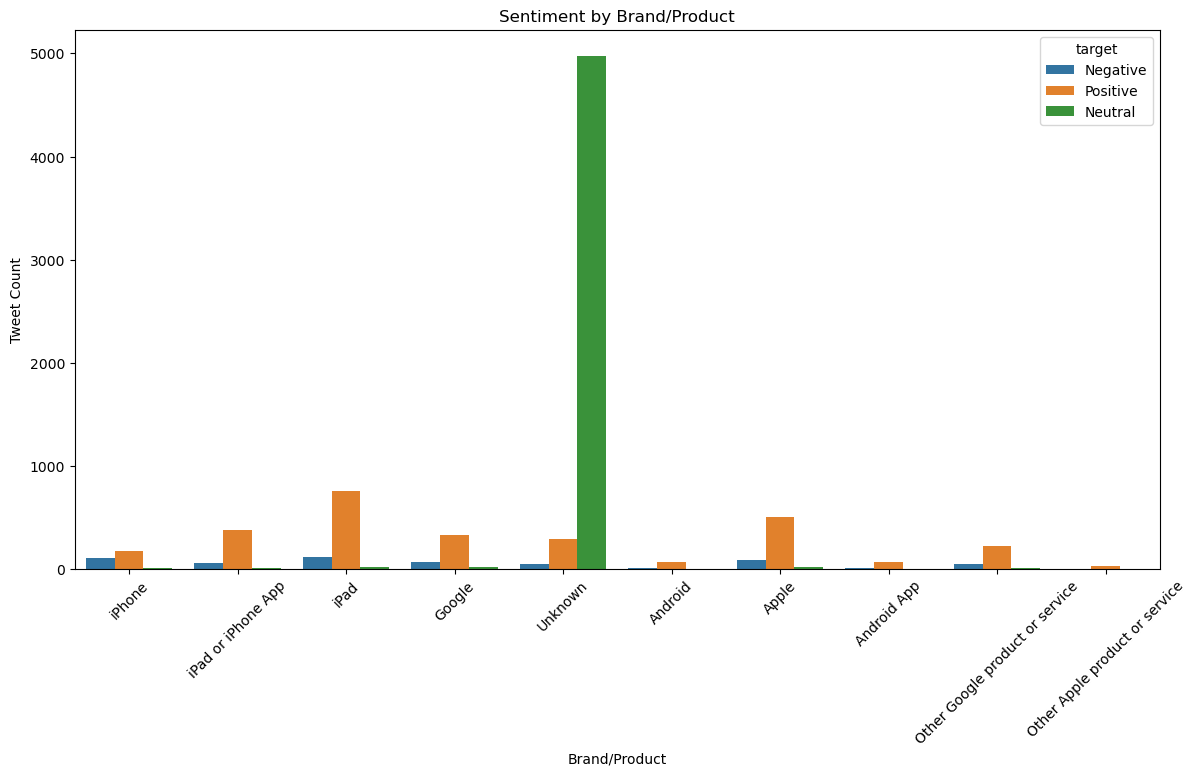

In [42]:
# Cross-tabulation of sentiment with directed brand/product (Multivariate)
# Count plot of sentiment for each directed brand/product (excluding NaN values)
plt.figure(figsize=(14, 7))
brand_sentiment_counts = df_cleaned[df_cleaned['product'].notnull()]
sns.countplot(data=brand_sentiment_counts, x='product', hue='target')
plt.title('Sentiment by Brand/Product')
plt.xlabel('Brand/Product')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.show() 

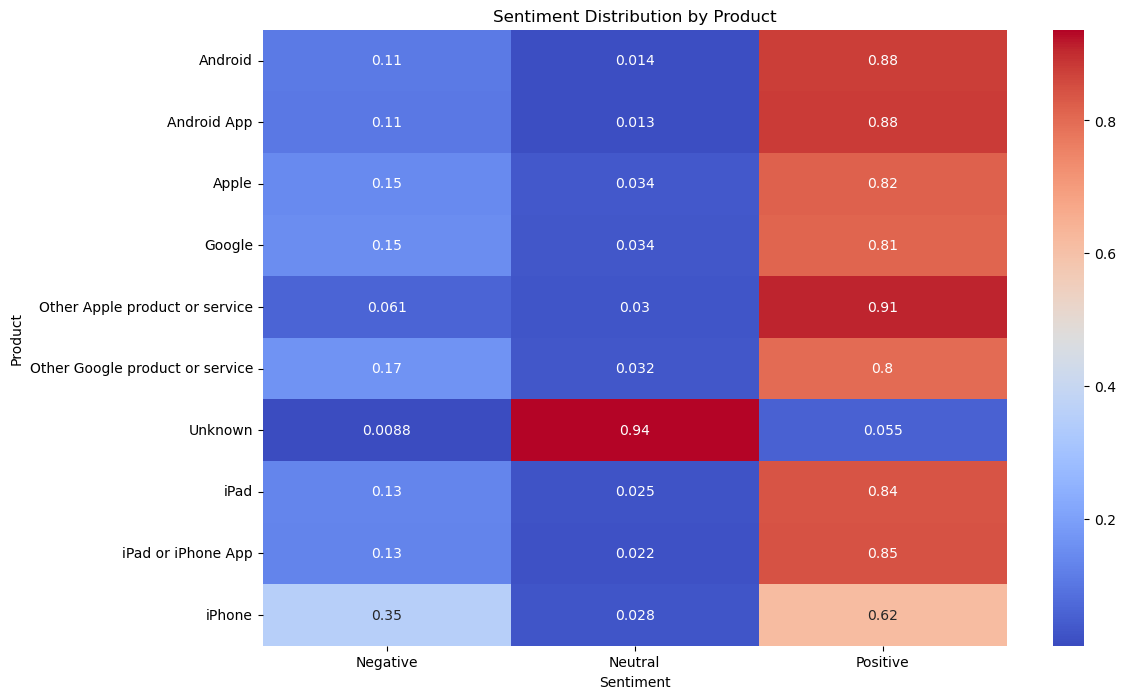

In [43]:
sentiment_distribution = df_cleaned.groupby('product')['target'].value_counts(normalize=True).unstack().fillna(0)
# Heatmap for sentiment correlation
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_distribution, annot=True, cmap='coolwarm')
plt.title('Sentiment Distribution by Product')
plt.xlabel('Sentiment')
plt.ylabel('Product')
plt.show()


### **4.0 Data Preparation**

#### **4.1 Label Encoding**

In [44]:
# We'll use One-Hot Encoding for the brands/products
df_encoded = pd.get_dummies(df_cleaned, columns=['product'], drop_first=True)

In [45]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8434 entries, 0 to 8433
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   tweet                                    8434 non-null   object
 1   target                                   8434 non-null   object
 2   cleaned_text                             8434 non-null   object
 3   tokens                                   8434 non-null   object
 4   lemmatized_tokens                        8434 non-null   object
 5   final_cleaned_text                       8434 non-null   object
 6   tweet_length                             8434 non-null   int64 
 7   product_Android App                      8434 non-null   bool  
 8   product_Apple                            8434 non-null   bool  
 9   product_Google                           8434 non-null   bool  
 10  product_Other Apple product or service   8434 non-null   boo

In [46]:
# Encoding the target column
le = LabelEncoder()
df_encoded['sentiment_encoded'] = le.fit_transform(df_cleaned['target'])

In [47]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8434 entries, 0 to 8433
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   tweet                                    8434 non-null   object
 1   target                                   8434 non-null   object
 2   cleaned_text                             8434 non-null   object
 3   tokens                                   8434 non-null   object
 4   lemmatized_tokens                        8434 non-null   object
 5   final_cleaned_text                       8434 non-null   object
 6   tweet_length                             8434 non-null   int64 
 7   product_Android App                      8434 non-null   bool  
 8   product_Apple                            8434 non-null   bool  
 9   product_Google                           8434 non-null   bool  
 10  product_Other Apple product or service   8434 non-null   boo

In [48]:
df_encoded.head()

,tweet,target,cleaned_text,tokens,lemmatized_tokens,final_cleaned_text,tweet_length,product_Android App,product_Apple,product_Google,product_Other Apple product or service,product_Other Google product or service,product_Unknown,product_iPad,product_iPad or iPhone App,product_iPhone,sentiment_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative,g iphone hrs tweeting dead need upgrade plugin...,"[g, iphone, hrs, tweeting, dead, need, upgrade...","[g, iphone, hr, tweeting, dead, need, upgrade,...",g iphone hr tweeting dead need upgrade plugin ...,127,False,False,False,False,False,False,False,False,True,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive,know awesome ipadiphone app youll likely appre...,"[know, awesome, ipadiphone, app, youll, likely...","[know, awesome, ipadiphone, app, youll, likely...",know awesome ipadiphone app youll likely appre...,139,False,False,False,False,False,False,False,True,False,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive,wait also sale,"[wait, also, sale]","[wait, also, sale]",wait also sale,79,False,False,False,False,False,False,True,False,False,2
3,@sxsw I hope this year's festival isn't as cra...,Negative,hope years festival isnt crashy years iphone app,"[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph...",hope year festival isnt crashy year iphone app,82,False,False,False,False,False,False,False,True,False,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive,great stuff fri marissa mayer google tim oreil...,"[great, stuff, fri, marissa, mayer, google, ti...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim oreil...,131,False,False,True,False,False,False,False,False,False,2


### **5.0 Modelling**

#### **5.1 Baseline Logistic Regression Model**

In [49]:
# Filter the dataset to exclude neutral sentiment and re-encode
df_filtered = df_encoded[df_encoded['sentiment_encoded'].isin([2, 0])].copy()  # Use .copy() to avoid warning
df_filtered.loc[:, 'sentiment_encoded'] = df_filtered['sentiment_encoded'].replace({2: 1})  # Map 2 to 1

In [50]:
# Split features and target
X = df_filtered['final_cleaned_text']
y = df_filtered['sentiment_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert sparse matrices to arrays for SMOTE
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

In [52]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Check the shape of the resampled data
print("Resampled X_train shape:", X_train_resampled.shape)
print("Resampled y_train value counts:\n", pd.Series(y_train_resampled).value_counts())

Resampled X_train shape: (4516, 4481)
Resampled y_train value counts:
 sentiment_encoded
1    2258
0    2258
Name: count, dtype: int64


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Positive       0.53      0.63      0.58       109
    Negative       0.93      0.89      0.91       565

    accuracy                           0.85       674
   macro avg       0.73      0.76      0.74       674
weighted avg       0.86      0.85      0.86       674



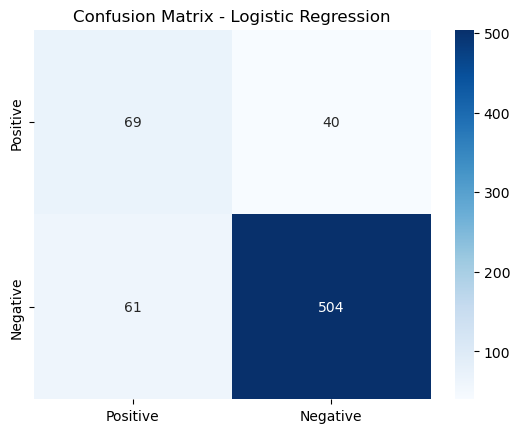

In [53]:
# Baseline Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred_lr = lr_model.predict(X_test_tfidf)

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Positive', 'Negative']))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


Accuracy: 0.85
ROC AUC: 0.88


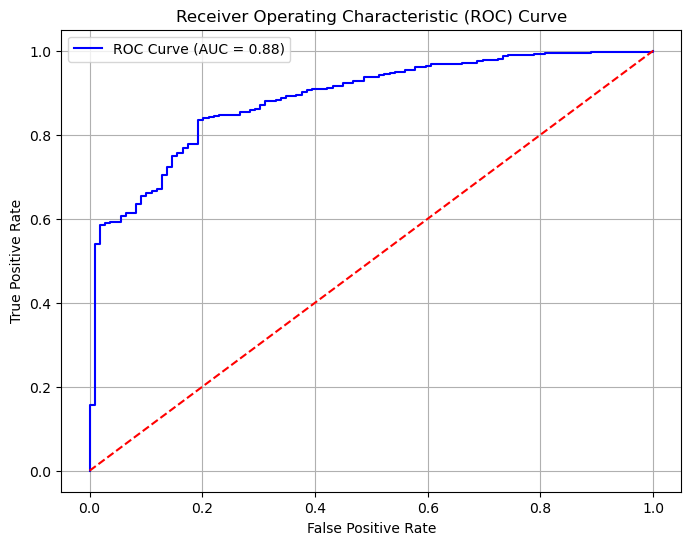

Cross-validation scores: [0.90265487 0.94684385 0.9379845  0.9379845  0.93576966]
Mean CV Accuracy: 0.93 ± 0.02


In [54]:
# Calculate accuracy and ROC AUC as before
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.2f}")

roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test_tfidf)[:, 1])
print(f"ROC AUC: {roc_auc:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test_tfidf)[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(lr_model, X_train_resampled, y_train_resampled, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

#### **5.2 Mutliclass Logistic Regression Model**

In [55]:
# Split the entire dataset
X = df_encoded['final_cleaned_text']
y = df_encoded['sentiment_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [57]:
# Bag of Words Model
bow_vectorizer = CountVectorizer(max_features=5000)

In [58]:
# Addressing Class Imbalance (if needed)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Check the shape of the resampled data
print("Resampled X_train shape:", X_train_resampled.shape)
print("Resampled y_train value counts:\n", pd.Series(y_train_resampled).value_counts())

Resampled X_train shape: (12162, 5000)
Resampled y_train value counts:
 sentiment_encoded
1    4054
2    4054
0    4054
Name: count, dtype: int64


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.29      0.56      0.38       108
     Neutral       0.75      0.65      0.70      1014
    Positive       0.55      0.58      0.56       565

    accuracy                           0.62      1687
   macro avg       0.53      0.60      0.55      1687
weighted avg       0.65      0.62      0.63      1687



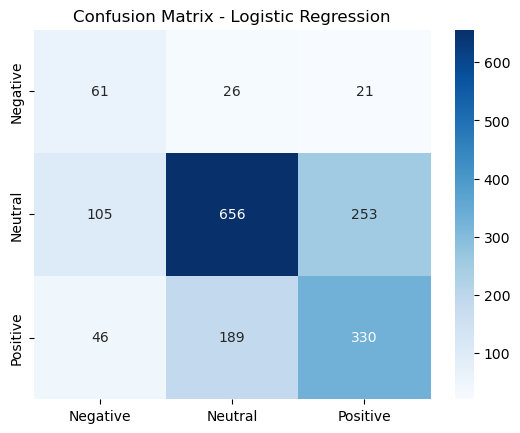

Accuracy: 0.62


In [59]:
# Multiclass Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')  # Specify multi_class and solver
lr_model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred_lr = lr_model.predict(X_test_tfidf)

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.2f}")

ROC AUC for class Negative: 0.86
ROC AUC for class Neutral: 0.72
ROC AUC for class Positive: 0.73
Micro-average ROC AUC: 0.77


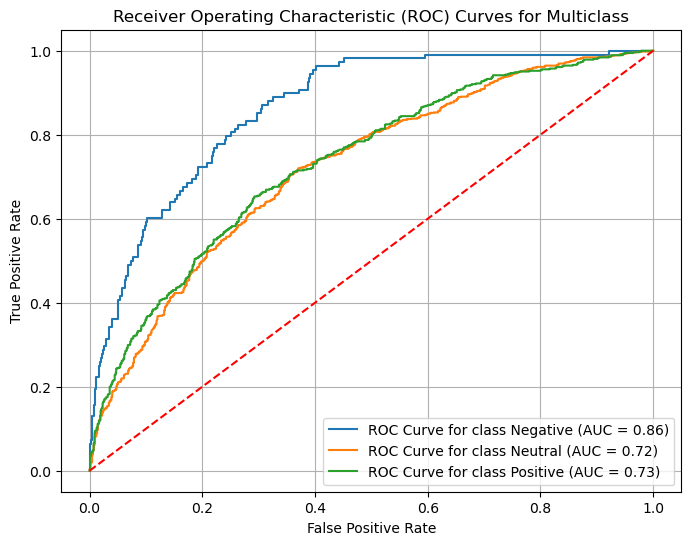

Cross-validation scores: [0.68074074 0.6962963  0.68272795 0.6864344  0.67976279]
Mean CV Accuracy: 0.69 ± 0.01


In [60]:
# Calculate probabilities for the test set
y_pred_proba = lr_model.predict_proba(X_test_tfidf)

# Calculate ROC AUC for each class
roc_auc_per_class = {}
for i in range(len(le.classes_)):
    # y_test == i generates a binary array indicating if the true label matches class i
    roc_auc_per_class[le.classes_[i]] = roc_auc_score(y_test == i, y_pred_proba[:, i])

# Print ROC AUC for each class
for cls, score in roc_auc_per_class.items():
    print(f"ROC AUC for class {cls}: {score:.2f}")

# Compute micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"Micro-average ROC AUC: {roc_auc_micro:.2f}")

# Compute ROC curve for each class and plot
plt.figure(figsize=(8, 6))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])  # Compute the ROC curve for the class
    plt.plot(fpr, tpr, label=f'ROC Curve for class {le.classes_[i]} (AUC = {roc_auc_per_class[le.classes_[i]]:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass')
plt.legend()
plt.grid()
plt.show()

# Cross-validation scores (using the multiclass model)
cv_scores_multiclass = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores_multiclass}")
print(f"Mean CV Accuracy: {cv_scores_multiclass.mean():.2f} ± {cv_scores_multiclass.std():.2f}")


#### **5.2 Multiclass Logistic Regression Model with Additional Features**

In [61]:
# Selecting relevant columns: cleaned text and product dummy variables
X = df_encoded.drop(columns=['sentiment_encoded','tweet','target','cleaned_text','tokens','lemmatized_tokens','tweet_length'])  # Exclude target variable
y = df_encoded['sentiment_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization for the 'final_cleaned_text' column
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['final_cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['final_cleaned_text'])

# Drop the 'final_cleaned_text' column from the feature set to use the dummy variables
X_train_dummies = X_train.drop(columns=['final_cleaned_text']).values
X_test_dummies = X_test.drop(columns=['final_cleaned_text']).values

# Combine TF-IDF features with product dummy features
X_train_combined = hstack([X_train_tfidf, X_train_dummies])
X_test_combined = hstack([X_test_tfidf, X_test_dummies])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# Check the shape of the resampled data
print("Resampled X_train shape:", X_train_resampled.shape)
print("Resampled y_train value counts:\n", pd.Series(y_train_resampled).value_counts())

# Multiclass Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred_lr = lr_model.predict(X_test_combined)


Resampled X_train shape: (12162, 5009)
Resampled y_train value counts:
 sentiment_encoded
1    4054
2    4054
0    4054
Name: count, dtype: int64


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55       108
           1       0.94      0.98      0.96      1014
           2       0.91      0.80      0.85       565

    accuracy                           0.89      1687
   macro avg       0.78      0.80      0.79      1687
weighted avg       0.90      0.89      0.89      1687



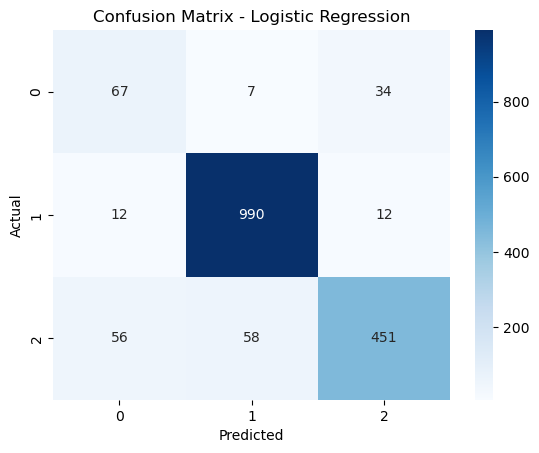

In [62]:
# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.89
ROC AUC for class 0: 0.94
ROC AUC for class 1: 0.95
ROC AUC for class 2: 0.93
Micro-average ROC AUC: 0.94


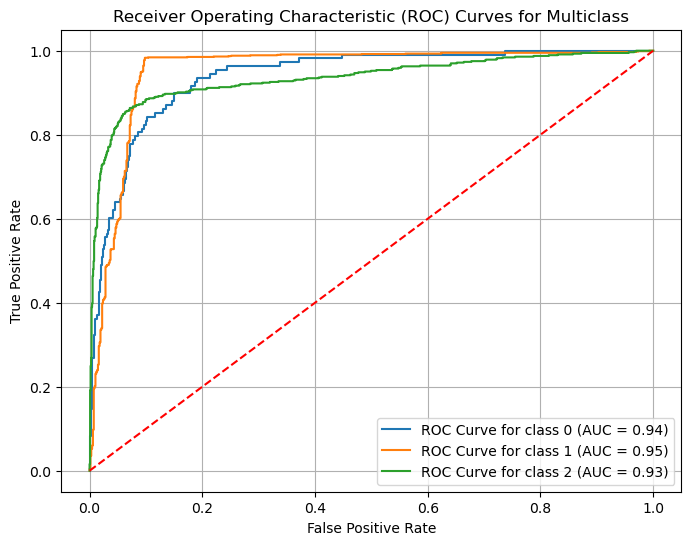

Cross-validation scores: [0.89925926 0.89111111 0.90585619 0.90140845 0.88584136]
Mean CV Accuracy: 0.90 ± 0.01


In [63]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.2f}")

# Calculate probabilities for the test set
y_pred_proba = lr_model.predict_proba(X_test_combined)

# Calculate ROC AUC for each class
roc_auc_per_class = {}
for i in range(len(np.unique(y))):
    roc_auc_per_class[i] = roc_auc_score(y_test == i, y_pred_proba[:, i])

# Print ROC AUC for each class
for cls, score in roc_auc_per_class.items():
    print(f"ROC AUC for class {cls}: {score:.2f}")

# Compute micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"Micro-average ROC AUC: {roc_auc_micro:.2f}")

# Compute ROC curve for each class and plot
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y))):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'ROC Curve for class {i} (AUC = {roc_auc_per_class[i]:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass')
plt.legend()
plt.grid()
plt.show()

# Cross-validation scores (using the multiclass model)
cv_scores_multiclass = cross_val_score(lr_model, X_train_combined, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores_multiclass}")
print(f"Mean CV Accuracy: {cv_scores_multiclass.mean():.2f} ± {cv_scores_multiclass.std():.2f}")
